In [1]:
# import libraries
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import safe as sf
import datamol as dm
from safe.utils import compute_side_chains
import csv
from rdkit import Chem
from rdkit import Chem, rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
from rdkit.Chem import Descriptors
import matplotlib as mpl
from rdkit import Chem

print('RDKit version: ',rdBase.rdkitVersion)
print('MatplotLib version:', mpl.__version__)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
/Users/ini-abasiaffiah/anaconda3/envs/safex/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ini-abasiaffiah/anaconda3/envs/safex/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/ini-abasiaffiah/anaconda3/envs/safex/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


RDKit version:  2023.09.5
MatplotLib version: 3.8.2


/Users/ini-abasiaffiah/anaconda3/envs/safex/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Scaffold Decoration
It requires side chains as input.

Steps:
* Get SMILES
* Extract core from SMILES (convert SMILES to molecule to do this)
* Finally, pass in cores to the model to generate the molecules for scaffold decoration.

In the rest of this notebook, I'll be playing around with codes to achieve different parts of this.

# Visualize Input SMILES

In [2]:
# read SMILES from .csv file, assuming one column with header
with open("data/my_molecules.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    smiles_list = [r[0] for r in reader]

dm.to_image(smiles_list)

FileNotFoundError: [Errno 2] No such file or directory: 'data/my_molecules.csv'

In [12]:
class MoleculeModel:
    def __init__(self, n_trials=10, n_samples_per_trial=10, lower_molecular_weight=60, upper_molecular_weight=100):
        self.designer = sf.SAFEDesign.load_default(verbose=True)
        self.n_trials = n_trials
        self.n_samples_per_trial = n_samples_per_trial
        self.lower_molecular_weight = lower_molecular_weight
        self.upper_molecular_weight = upper_molecular_weight

    def smiles_to_safe(self, smiles):
        try:
            return sf.encode(smiles)
        except Exception as e:
            print(f" Error in SMILES conversion: {e}")
            return None

    def _extract_core_structure(self, safe):
        # Define scaffold parameter network
        params = rdScaffoldNetwork.ScaffoldNetworkParams()
        # customize parameter attributes
        params.includeScaffoldsWithoutAttachments=False
        if safe is not None:
            mol = Chem.MolFromSmiles(safe)
            net = rdScaffoldNetwork.CreateScaffoldNetwork([mol],params)
            nodemols = [Chem.MolFromSmiles(x) for x in net.nodes]

            filtered_list = []
            for mol in nodemols:
                # Check for the presence of attachment points and molecular weight range
                if "*" in Chem.MolToSmiles(mol) and self.lower_molecular_weight < Descriptors.MolWt(mol) < self.upper_molecular_weight:
                    filtered_list.append(mol)
            
            # If there are no scaffolds within the range, select the closest one
            if not filtered_list:
                closest_mol = min(nodemols, key=lambda x: abs(Descriptors.MolWt(x) - (self.lower_molecular_weight + self.upper_molecular_weight) / 2))
                filtered_list.append(closest_mol)
            
            # Sort the filtered list based on the number of heteroatoms (fewer carbons)
            filtered_list.sort(key=lambda x: x.GetNumHeavyAtoms())

            return filtered_list
        else:
            return None

    
    def _generate_smiles(self, scaffold):
        generated_smiles = self.designer.scaffold_decoration(
        scaffold=scaffold,
        n_samples_per_trial=10,
        n_trials=10,
        sanitize=True,
        do_not_fragment_further=True,
                )
        return generated_smiles


    def run_model(self, safe):
        generated_smiles = []
        for i in safe:
            row = []
            if i is not None:
                core_structures = self._extract_core_structure(i)
                for core in core_structures:
                    output = self._generate_smiles(core)
                    row += output
                generated_smiles += [row]
            else:
                generated_smiles += [row]
        return generated_smiles


In [13]:
designer = MoleculeModel()

# Convert to SAFE
safe_list = [designer.smiles_to_safe(smi) for smi in smiles_list]

# run model
outputs = designer.run_model(safe_list)

#check input and output have the same lenght
input_len = len(smiles_list)
output_len = len(outputs)
assert input_len == output_len

# write output in a .csv file
with open("decoration.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["value"])  # header
    for o in outputs:
        writer.writerow([o])

[07:08:51] Running LargestFragmentChooser
  0%|          | 0/10 [00:00<?, ?it/s]/Users/ini-abasiaffiah/anaconda3/envs/safex/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Fa

# Visuals

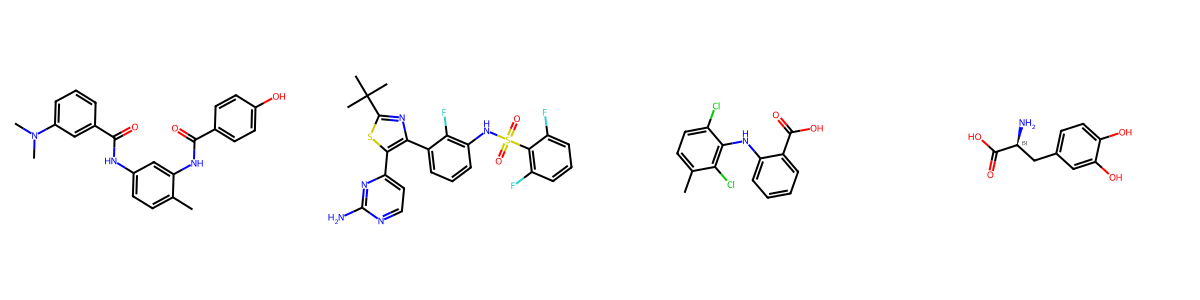

In [10]:
smiles_list = ["CN(C)c1cccc(c1)C(=O)Nc1ccc(C)c(NC(=O)c2ccc(O)cc2)c1", 
               "CC(C)(C)c1nc(c(s1)-c1ccnc(N)n1)-c1cccc(NS(=O)(=O)c2c(F)cccc2F)c1F",
               "Cc1ccc(Cl)c(Nc2ccccc2C(O)=O)c1Cl",
               "N[C@@H](Cc1ccc(O)c(O)c1)C(O)=O"
               ]
dm.to_image(smiles_list)

## SMILES 1: "CN(C)c1cccc(c1)C(=O)Nc1ccc(C)c(NC(=O)c2ccc(O)cc2)c1"

In [4]:
# convert SMILES to SAFE
def smiles_to_safe(smiles):
    try:
        safe = sf.encode(smiles)
        return safe
    # except sf.EncoderError:
    except:
        print("Error in SMILES conversion")


def extract_core_structure(SMILES):
    # Define scaffold parameter network
    params = rdScaffoldNetwork.ScaffoldNetworkParams()
    # customize parameter attributes
    params.includeScaffoldsWithoutAttachments=False
    mol = Chem.MolFromSmiles(SMILES)
    net = rdScaffoldNetwork.CreateScaffoldNetwork([mol],params)
    nodemols = [Chem.MolFromSmiles(x) for x in net.nodes]

    filtered_list = []
    for mol in nodemols:
        # Check for the presence of attachment points and molecular weight range
        if "*" in Chem.MolToSmiles(mol) and 60 < Descriptors.MolWt(mol) < 100:
            filtered_list.append(mol)

    # If there are no scaffolds within the range, select the closest one
    if not filtered_list:
        closest_mol = min(nodemols, key=lambda x: abs(Descriptors.MolWt(x) - 80))
        filtered_list.append(closest_mol)

    # Sort the filtered list based on the number of heteroatoms (fewer carbons)
    filtered_list.sort(key=lambda x: x.GetNumHeavyAtoms())

    return filtered_list


designer = sf.SAFEDesign.load_default(verbose=True)
safe = smiles_to_safe(smiles_list[0])
print(safe)
# modify the core structure by adding square brackets around *
core_structures = extract_core_structure(safe)
modified_structures = [Chem.MolToSmiles(core).replace('*', '[*]') for core in core_structures]  # it generates outputs when i use this...
print(modified_structures)

c16ccc(C)c7c1.c15cccc8c1.c19ccc(O)cc1.CN5C.C38=O.C49=O.N36.N47
['[*]c1ccccc1', '[*]c1cccc([*])c1']


[14:02:29] Running LargestFragmentChooser


#### Visualize the Extracted Cores

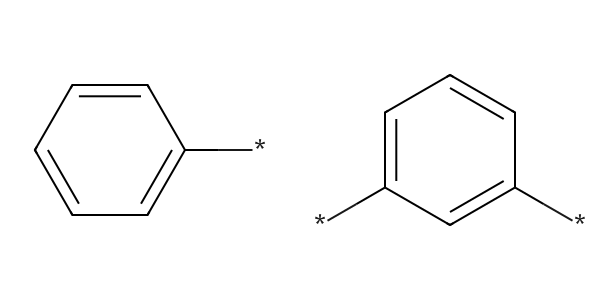

In [11]:
dm.to_image(modified_structures)

#### Use the first core structure

In [6]:
generated_smiles = designer.scaffold_decoration(
    scaffold=modified_structures[0],
    n_samples_per_trial=10,
    n_trials=10,
    sanitize=True,
    do_not_fragment_further=True,
)

print(generated_smiles)
generated_mols = [dm.to_mol(x) for x in generated_smiles]

  0%|          | 0/10 [00:00<?, ?it/s]

2024-02-20 14:04:33.233 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 84 / 100 (84.00 %)  generated molecules are valid !


['N#CCCCCN(C(N)=[NH+]CCCC(F)(F)F)c1ccccc1', 'O=C(/C=N/O)NCCOCCc1ccccc1', 'NS(=O)(=NS(=O)(=O)N[C@H](CCC(=O)[O-])c1ccccc1)N(F)C(F)(F)F', 'O=C(CSCC(F)(F)F)N[C@H](Cc1ccccc1)[C@@H](O)C(F)F', 'NC(=O)C[C@@H](NC(=O)NCCOCC(=O)[O-])c1ccccc1', 'O=C(NCCCCCCO)NOCc1ccccc1', 'O=C([O-])COCC(=O)N[C@@H](Cc1ccccc1)C(=O)[O-]', 'Cl[C@@H](CCCCCCN1CCCC1)Cc1ccccc1', 'NC(=N[N+](=O)[O-])c1ccccc1', 'OCCCCCCCCSSc1ccccc1', 'OC[C@@H](O)CC/C=N\\OCc1ccccc1', 'O=C([O-])C(=O)NCC[S+]([O-])Cc1ccccc1', 'O=C(NCC[S+]([O-])Cc1ccccc1)N[C@H](CC(F)F)C(=O)[O-]', 'O=C(CSCc1ccccc1)OCCOCC(F)(F)C(F)(F)F', 'O=C(NO)C(F)(F)S(=O)(=O)c1ccccc1', 'O=C([O-])CCCCCCNC(=O)CNC(=O)CCOc1ccccc1', 'N#CCCN(CCC#N)C(=O)COC(=O)[C@H](CCC(F)(F)F)c1ccccc1', 'O=C(CCC(F)F)NC(=O)NCc1ccccc1', 'O=C(CCNC(=O)Nc1ccccc1)NC(CO)CO', 'O=C([O-])CN=NS(=O)(=O)Cc1ccccc1', 'O=C([O-])C[C@@H](CCO)CNC(=O)C(=O)Nc1ccccc1', 'N#CCCCCNC(=S)N[C@@H](c1ccccc1)C(F)(F)F', 'O=C(N[C@H](CCO)c1ccccc1)[C@@H](F)C(F)(F)F', 'O=C(NCCCOCc1ccccc1)NCCCOC(F)F', 'O=C([O-])CNC(=O)C[C@H](c1ccccc1)C(F

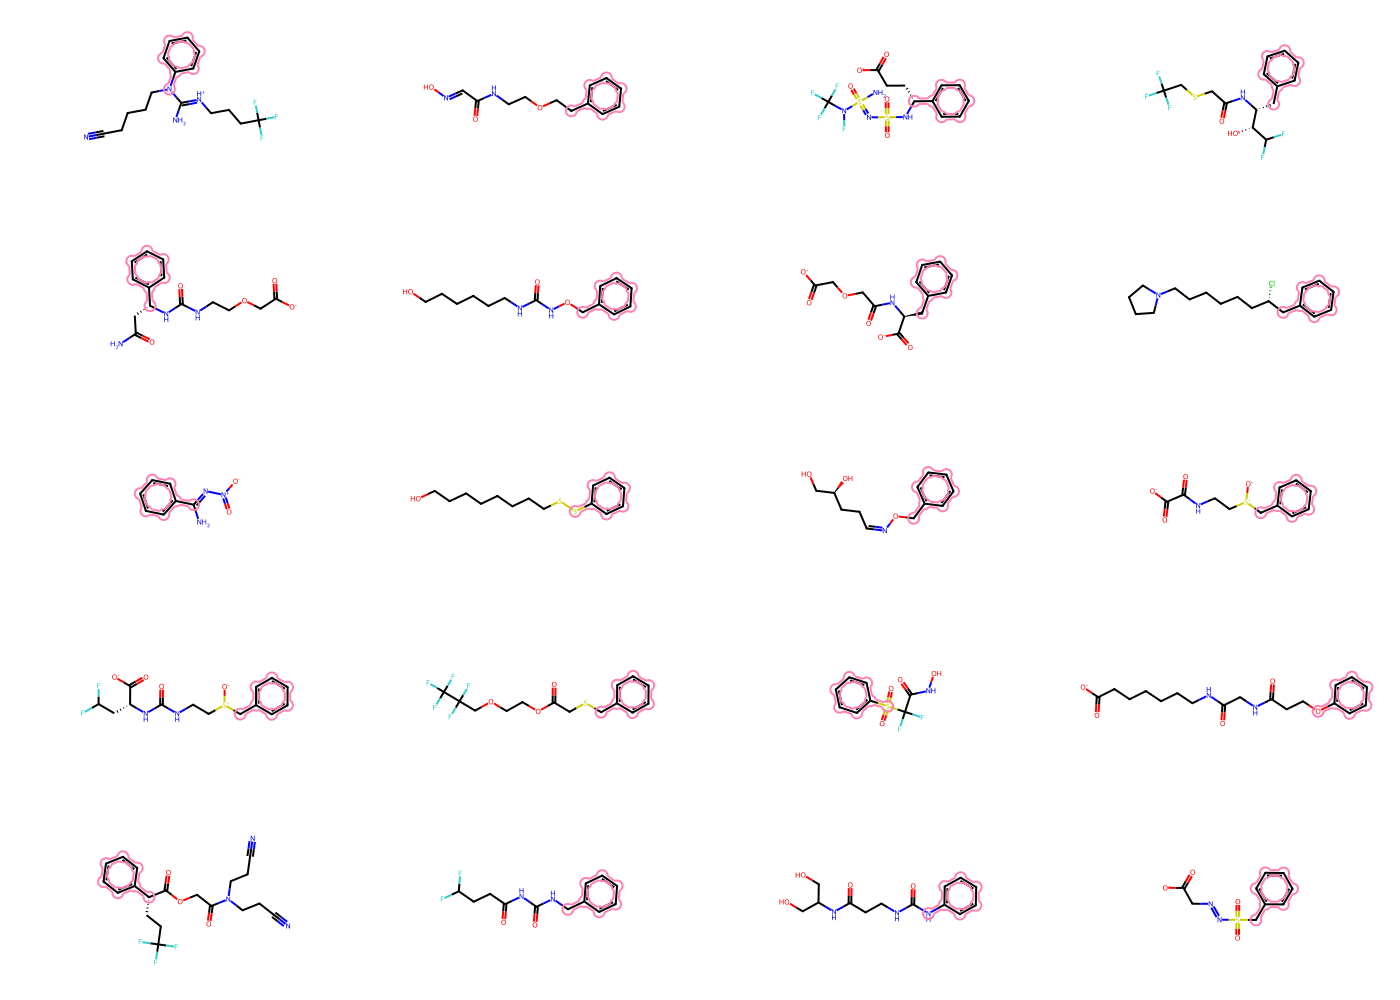

In [7]:
# View the first 20 generated molecules
dm.viz.lasso_highlight_image(generated_mols[:20], 
                             dm.from_smarts(modified_structures[0]), 
                             mol_size=(350, 200), 
                             color_list=["#ff80b5"], 
                             scale_padding=0.1)

#### Use the second core structure

In [8]:
generated_smiles = designer.scaffold_decoration(
    scaffold=modified_structures[1],
    n_samples_per_trial=10,
    n_trials=10,
    sanitize=True,
    do_not_fragment_further=True,
)

print(generated_smiles)
generated_mols = [dm.to_mol(x) for x in generated_smiles]

[14:05:27] Explicit valence for atom # 12 O, 3, is greater than permitted
2024-02-20 14:05:27.582 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 96 / 100 (96.00 %)  generated molecules are valid !


['OCC(CO)N=C(O)C(F)(F)c1cccc(C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)c1', 'Cl[Si](Cl)(Cl)C#Cc1cccc(C#C[Si](Cl)(Cl)Cl)c1', 'N=C(NO)c1cccc(S(=O)(=O)C(F)F)c1', 'NC(=O)c1cccc(C(=O)[O-])c1', 'NNS(=O)(=O)c1cccc(C(F)(F)F)c1', 'FC(F)(F)CCCNC(=S)Nc1cccc(OC(F)(F)F)c1', 'ClCc1cccc(CI)c1', 'O=C([O-])CC[C@@H](O)C(=O)Oc1cccc(OC(F)F)c1', 'NC(=O)c1cccc(NC(=O)CCCCCCCO)c1', 'FC(F)(F)c1cccc(OCCCCCS)c1', 'O=S(=O)([O-])c1cccc(N=NC(F)(F)C(F)(F)F)c1', 'FC(F)(F)c1cccc(CCBr)c1', 'O=C(CCc1cccc(CO)c1)N[C@@H](CO)C(=O)[O-]', 'O=NC(F)(F)Oc1cccc(C(=O)CC(=O)[O-])c1', 'O=CCc1cccc(C=CC(=O)O)c1', 'NC(=O)c1cccc(NC(N)=[NH+]C[C@@H](O)C(F)(F)F)c1', 'O=C([O-])Cc1cccc(OCCC(F)(F)F)c1', 'OCC#Cc1cccc(C#CCO)c1', 'PPN=Nc1cccc(N=NPP)c1', 'N#CCc1cccc(NC(=S)NC[C@H](O)C(N)=O)c1', 'N[C@@H](Cc1cccc(CO)c1)C(F)F', 'ClP(Cl)(Cl)(Cl)c1cccc(P(Cl)(Cl)(Cl)Cl)c1', 'N=C(CN)c1cccc([N+](=O)[O-])c1', 'OCC(O)c1cccc(C(F)(F)F)c1', 'O=C(CCc1cccc(OC(F)(F)F)c1)N=CCC(=O)C(F)(F)F', 'N#CN=C(NCCC(O)=NN)Nc1cccc(-c2ccccc2)c1', 'NNc1cccc(N=S)c1', 'O=CCOc1cccc(C(F)F)c1', '

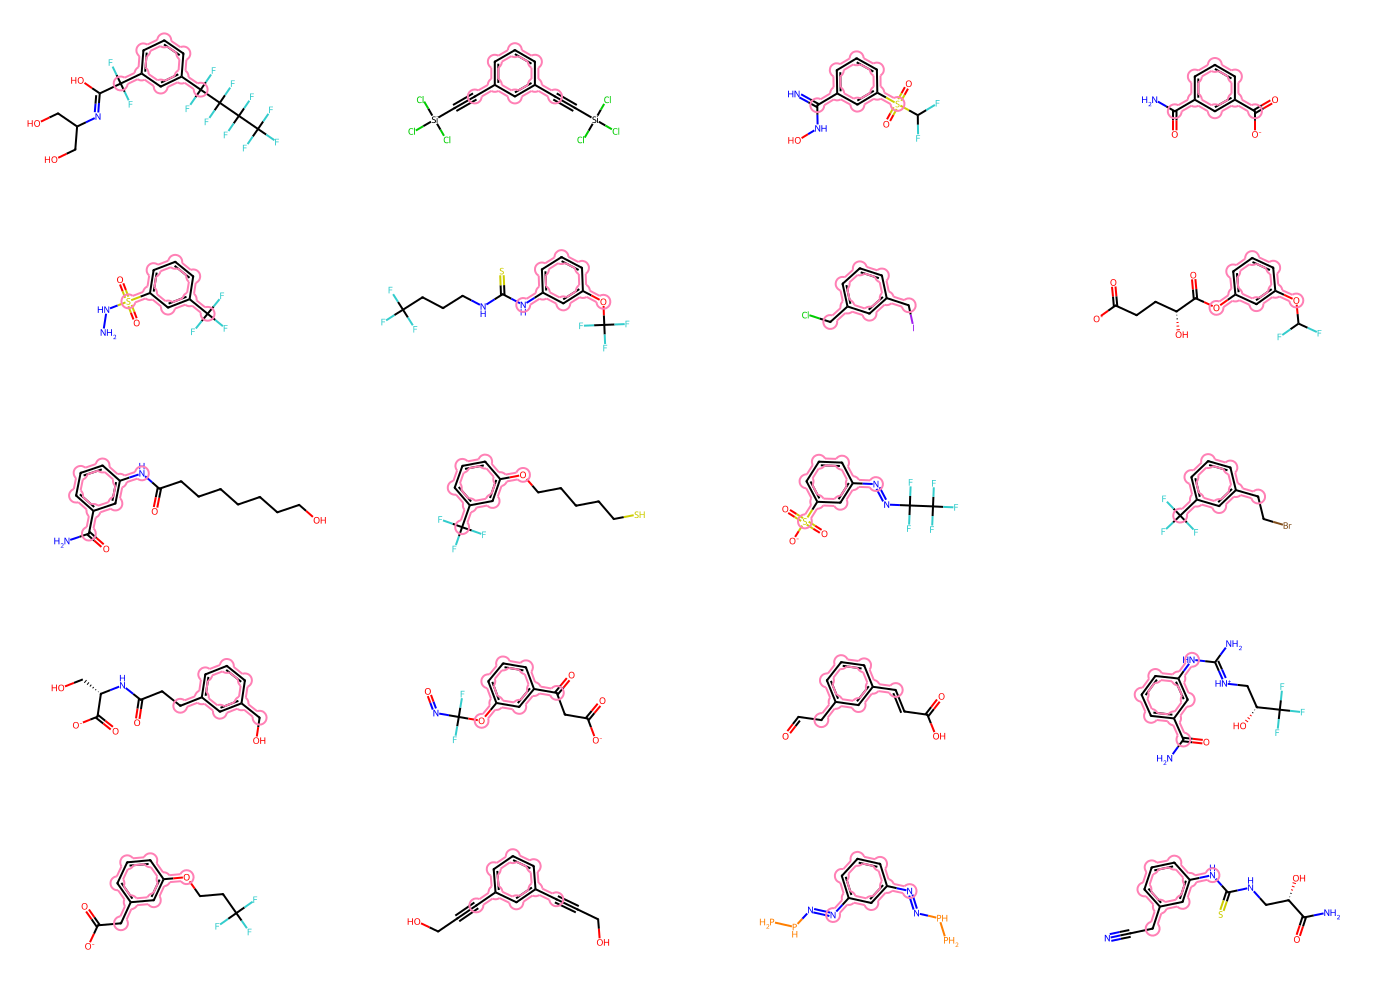

In [9]:
# View the first 20 generated molecules
dm.viz.lasso_highlight_image(generated_mols[:20], 
                             dm.from_smarts(modified_structures[1]), 
                             mol_size=(350, 200), 
                             color_list=["#ff80b5"], 
                             scale_padding=0.1)

## SMILES 2: "CC(C)(C)c1nc(c(s1)-c1ccnc(N)n1)-c1cccc(NS(=O)(=O)c2c(F)cccc2F)c1F"

In [11]:
safe = smiles_to_safe(smiles_list[1])
print(safe)
# modify the core structure by adding square brackets around *
core_structures = extract_core_structure(safe)
modified_structures = [Chem.MolToSmiles(core).replace('*', '[*]') for core in core_structures]  # it generates outputs when i use this...
print(modified_structures)

S3(=O)(=O)c1c(F)cccc1F.c17cccc4c1F.c15nc7c6s1.c16ccnc(N)n1.CC5(C)C.N34
['[*]c1ncsc1[*]', '[*]c1ccccc1', '[*]c1ccncn1', '[*]c1cccc([*])c1']


[14:07:48] Running LargestFragmentChooser


#### Visualize the cores

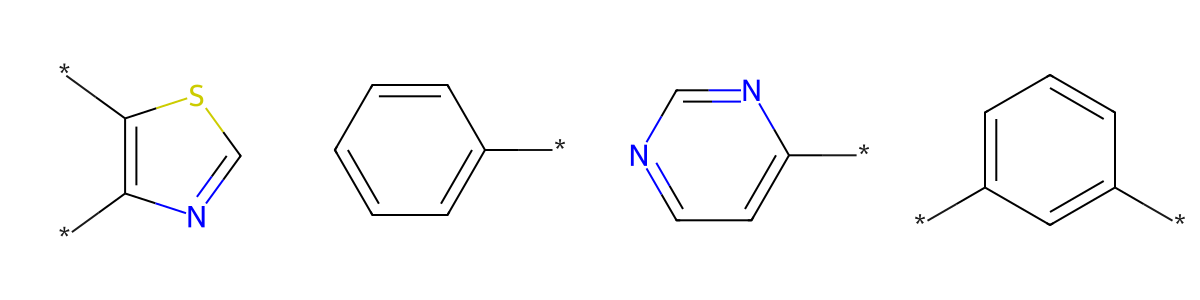

In [12]:
dm.to_image(modified_structures)

#### Use the first core

In [13]:
generated_smiles = designer.scaffold_decoration(
    scaffold=modified_structures[0],
    n_samples_per_trial=10,
    n_trials=10,
    sanitize=True,
    do_not_fragment_further=True,
)

print(generated_smiles)
generated_mols = [dm.to_mol(x) for x in generated_smiles]

2024-02-20 14:10:01.519 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 97 / 100 (97.00 %)  generated molecules are valid !


['FC(F)Oc1ncsc1CCCCCS', 'OCc1ncsc1CCC(F)(F)F', 'FC(F)(F)c1ncsc1C(F)(F)F', 'FC(F)CN=NCc1ncsc1C(F)(F)F', 'F[B-](F)(F)Oc1scnc1C(F)(F)F', 'Fc1cncc(-c2ncsc2C(F)(F)F)c1', 'FC(F)c1scnc1-c1ccc[nH]1', 'O=C(NCCCOC(F)F)c1ncsc1C(F)(F)F', 'O=C([O-])c1ncsc1NCCCOCC(F)(F)F', 'O=C(CBr)c1ncsc1C(F)(F)F', 'FC(F)C(F)c1scnc1C(F)(F)F', 'O=C(NCCCCCO)c1scnc1C(F)(F)F', 'NC(=O)c1scnc1[C@@H]1CNCCO1', 'OCc1scnc1-c1cnnn1CC1CCCO1', 'FC(F)(F)c1scnc1CC1CC1', 'FC(F)(F)c1scnc1[C@H]1CCCCCN1', 'O=C(NCCCCCCCCCCCCO)c1scnc1C(F)F', 'O=C([O-])CCCCS(=O)(=O)c1ncsc1[N+](=O)[O-]', 'OCc1scnc1CCl', 'FC(F)c1scnc1[C@@H]1CCNC1', 'FC(F)(F)c1ncsc1CBr', 'FC(F)Oc1ncsc1CS', 'O=NC(c1ncsc1C(F)(F)Br)C(F)(F)F', 'FC(F)(F)CCc1scnc1C1CCCNC1', 'O=CCCCCCCc1ncsc1C(F)(F)F', 'FC(F)(F)c1scnc1[C@@H]1CNCCO1', 'FC(F)c1scnc1C(F)(F)F', 'ClCc1scnc1C1OCCO1', 'FC(F)(F)c1scnc1C1CNOC1', 'FC(F)c1scnc1C(F)(F)F', 'NC(=O)c1ncsc1C(F)(F)F', 'O=C([O-])c1ncsc1C(=O)[O-]', 'O=C(O)Nc1scnc1C1CCCNC1', 'FC(F)c1scnc1CCl', 'FC(F)(F)c1scnc1[C@H]1CNCCO1', 'OCc1ncsc1CCCCCBr', 'O=C(

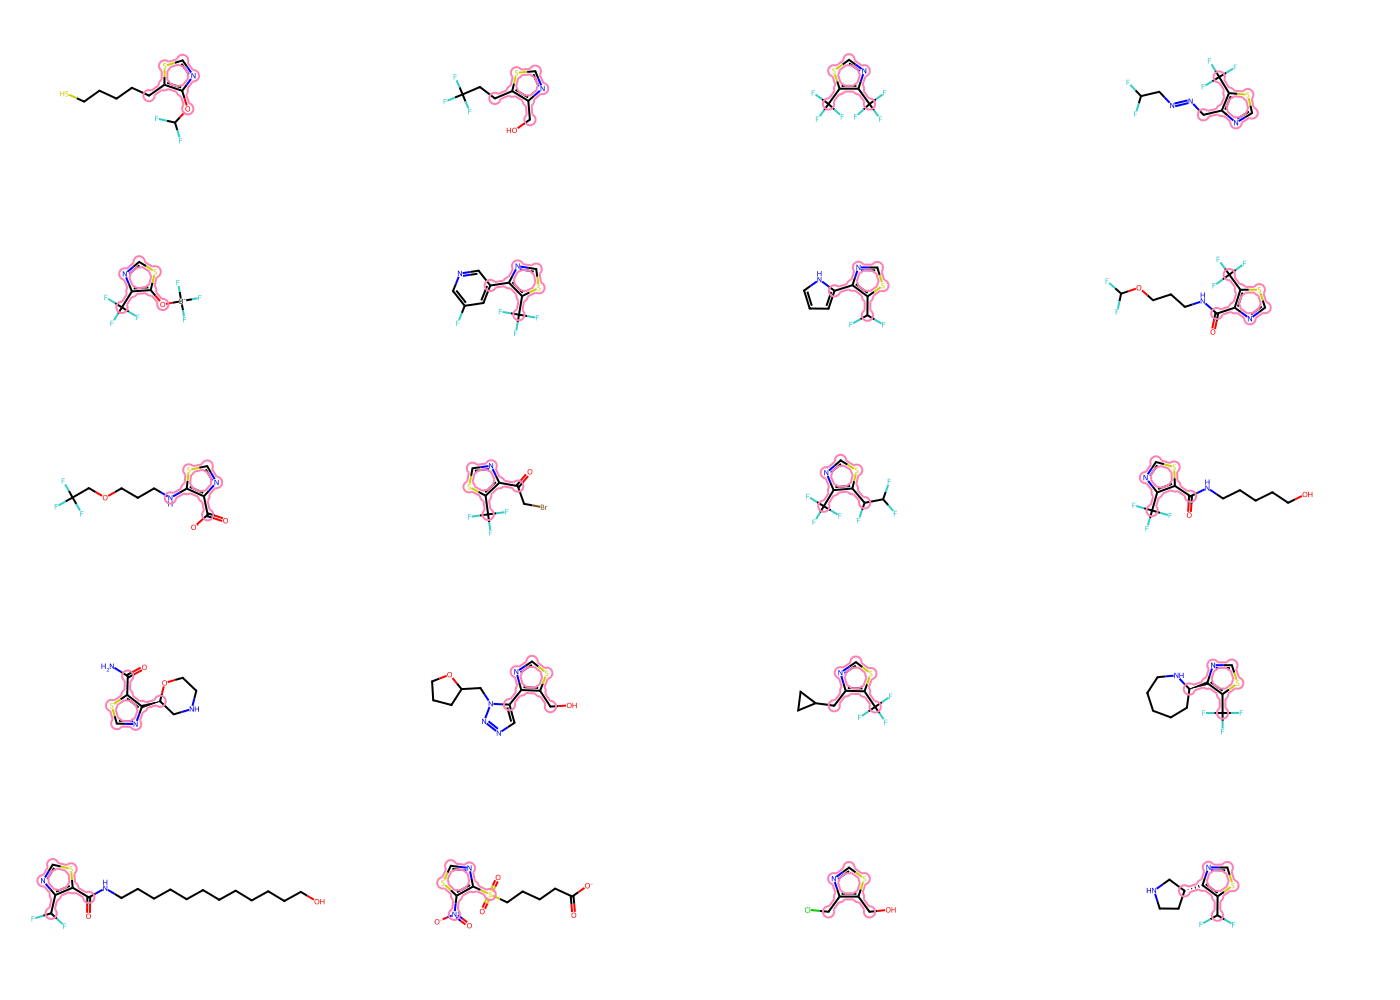

In [14]:
# View the first 20 generated molecules
dm.viz.lasso_highlight_image(generated_mols[:20], 
                             dm.from_smarts(modified_structures[0]), 
                             mol_size=(350, 200), 
                             color_list=["#ff80b5"], 
                             scale_padding=0.1)

### Use the third core

In [15]:
generated_smiles = designer.scaffold_decoration(
    scaffold=modified_structures[2],
    n_samples_per_trial=10,
    n_trials=10,
    sanitize=True,
    do_not_fragment_further=True,
)

print(generated_smiles)
generated_mols = [dm.to_mol(x) for x in generated_smiles]

Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
2024-02-20 14:10:59.118 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 99 / 100 (99.00 %)  generated molecules are valid !


['FC(F)(F)C(F)(F)CN=Nc1ccncn1', 'ClCc1csc(-c2ccncn2)n1', 'NC1CC1CCNc1ccncn1', 'NNCc1ccncn1', 'ClCOc1ccncn1', 'c1cc(C2CCCOC2)ncn1', 'O=C(CCOCC(F)(F)C(F)F)NCc1ccncn1', 'O=C([O-])CCSc1ccncn1', 'c1cc(NC2=NCCCC2)ncn1', 'NC(=O)CCCCCc1ccncn1', 'NCCc1ccncn1', 'O=C(Cc1ccncn1)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', 'N#CCc1ccncn1', 'c1cc(C2CCCCN2C[C@@H]2CCOC2)ncn1', 'NC(CCC(F)(F)F)=[NH+]OCC(=O)c1ccncn1', 'NC(F)Oc1ccncn1', 'NC(NCc1ccncn1)=[NH+]C[C@H](O)CC(F)(F)F', 'ONc1ccncn1', 'OCCc1ccncn1', 'NOCC(=O)c1ccncn1', 'FC(F)(F)Cc1ccncn1', 'Br/C=C/c1ccncn1', 'BrCCc1ccncn1', 'BrCCCCc1ccncn1', 'NC(N)=NCCCc1ccncn1', 'C1=CC(P(=Nc2ccncn2)(c2ccncc2)C2C=CC=C2)C=C1', 'Nc1c[nH]nc1-c1ccncn1', 'c1cc(C2CCCNC2)ncn1', 'NS(=O)(CC(F)(F)F)=Nc1ccncn1', 'c1cc(P2CO2)ncn1', 'NS(N)(=O)=NC(=O)Cc1ccncn1', 'OCCCNCc1ccncn1', 'N[C@H](CCC(=O)[O-])c1ccncn1.[Li+]', 'O=S(=O)(Cc1ccncn1)NCCOC(F)(F)F', 'O=C(/C=N/c1ccncn1)C(F)(F)F', 'O=C([O-])CCc1ccncn1', 'O=C(CC(=O)OCC(F)(F)C(F)(F)C(F)(F)F)Cc1ccncn1', 'c1cc(NN2CCNCC2)ncn1', 'O=[N+]([O-])c1ccncn1

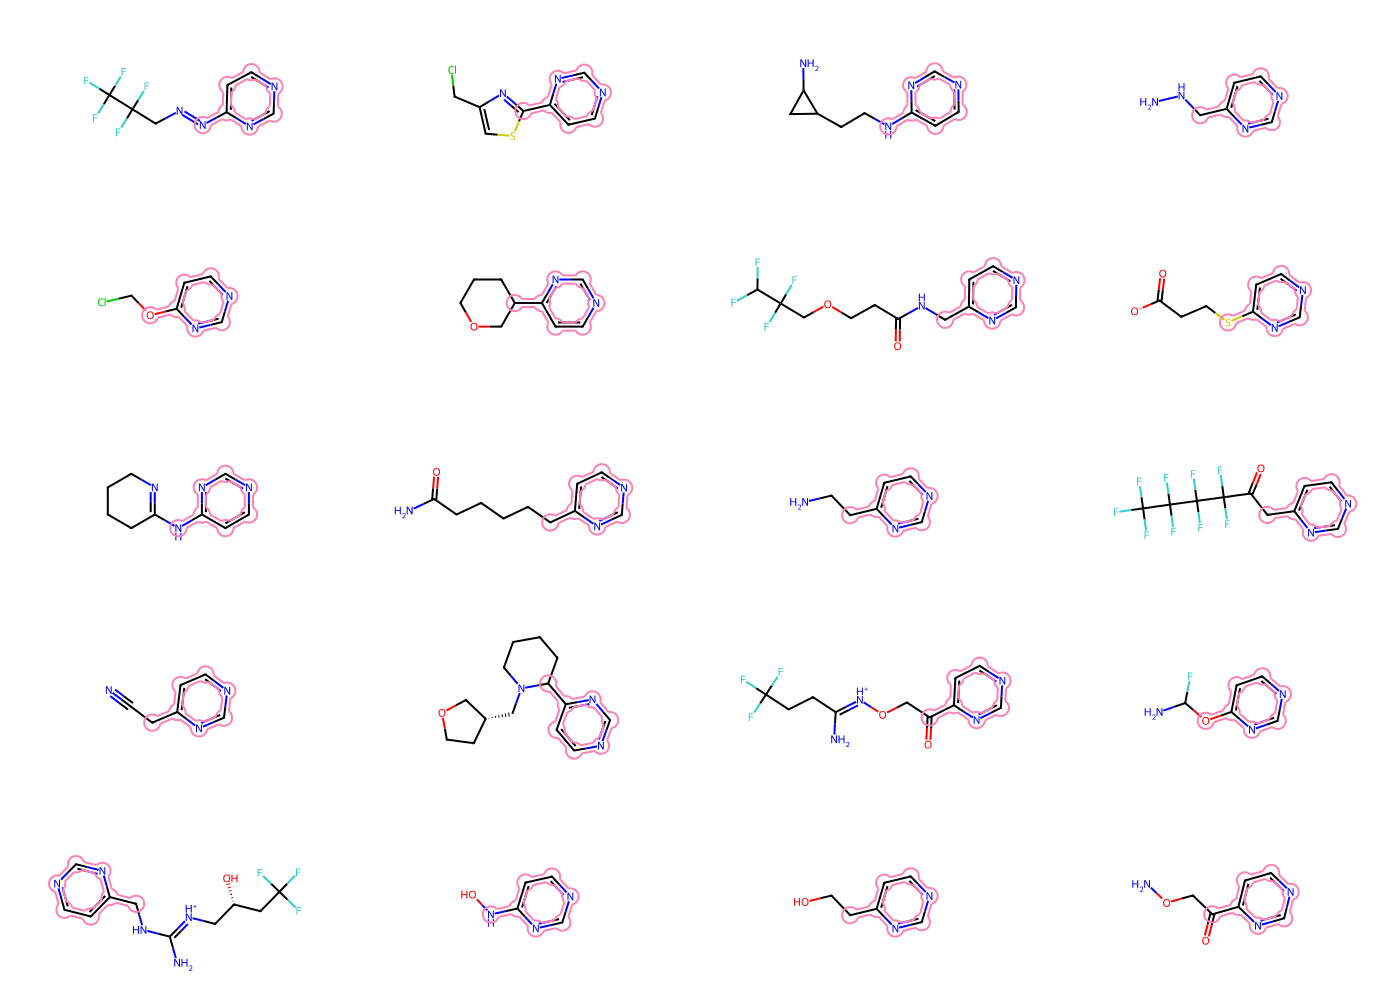

In [16]:
# View the first 20 generated molecules
dm.viz.lasso_highlight_image(generated_mols[:20], 
                             dm.from_smarts(modified_structures[2]), 
                             mol_size=(350, 200), 
                             color_list=["#ff80b5"], 
                             scale_padding=0.1)